In [1]:
AVAILABLE_GPU = 3 # Available GPU with 0% usage
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = f"{AVAILABLE_GPU}"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
tf_device=f'/gpu:{AVAILABLE_GPU}'

In [2]:
import sys
sys.path.append('../Utils')

In [3]:
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, BertModel

from DataManagement import preparar_datos
from Constants import SEED
from DataManagement import createDataloaders
from Utils import get_loss_opt
from Utils import train
from Utils import count_parameters
from Models import SentimentAnalysis
from Utils import verify_model
from Constants import TRAINING_DATA

/home/historynlp/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print(f"Memoria total reservada en CUDA: {torch.cuda.memory_reserved(0)} bytes")
print(f"Memoria actualmente asignada en CUDA: {torch.cuda.memory_allocated(0)} bytes")

Memoria total reservada en CUDA: 0 bytes
Memoria actualmente asignada en CUDA: 0 bytes


# 1. Definición de constantes

In [5]:
#Modelo bert a usar
BERT_MODEL = 'finiteautomata/beto-sentiment-analysis'

#Dispositivo sobre el que se corre el modelo de ML
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)

# 2. Creacion de los dataLoaders

In [6]:
datos = preparar_datos(TRAINING_DATA)
train_df, test_df = train_test_split(datos, test_size=0.2, random_state = SEED, shuffle=True)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state = SEED, shuffle=True)

train_loader, val_loader, test_loader = createDataloaders(train_df, val_df, test_df, tokenizer)

# 3. Creación y evaluación del modelo con Bert Entrenado

## 3.1 Entrenamiento

In [7]:
torch.manual_seed(SEED)
classificator = SentimentAnalysis(BERT_MODEL, 0.4, 4, 256, 128, True).to(DEVICE)
count_parameters(classificator)

110084228

In [8]:
criterio, optimizer = get_loss_opt(classificator)
train(classificator, '../StoredModels/Mejores_guardados.pt', train_loader, val_loader, optimizer, criterio)

 32%|█████████████▌                             | 19/60 [16:04<30:48, 45.09s/it]


Epoch: 20 | Training acc: 0.6103430619559652 | Training loss: 0.1084251746542931 | Val acc: 0.680327868852459 | Val loss: 0.10937955071691607
------------------------------------------------------------------------------------------------------------------------------------------------------


 65%|███████████████████████████▉               | 39/60 [31:00<15:38, 44.69s/it]


Epoch: 40 | Training acc: 0.6948284690220174 | Training loss: 0.10151982942240334 | Val acc: 0.6680327868852459 | Val loss: 0.11085418917116571
------------------------------------------------------------------------------------------------------------------------------------------------------


 98%|██████████████████████████████████████████▎| 59/60 [45:53<00:44, 44.65s/it]


Epoch: 60 | Training acc: 0.6815156169994879 | Training loss: 0.10420133160494928 | Val acc: 0.639344262295082 | Val loss: 0.11004673433108408
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|███████████████████████████████████████████| 60/60 [45:53<00:00, 45.90s/it]


(inf, 0.6999487967229903)

## 3.2 Evaluación

In [8]:
# Cargar un modelo que ya había sido Finetuneado
checkpoint_classifier = torch.load(
    "../StoredModels/Mejores_guardados.pt",
    map_location=torch.device(DEVICE)
)

classificator.load_state_dict(checkpoint_classifier['model_state_dict'])

<All keys matched successfully>

100%|███████████████████████████████████████████| 31/31 [00:02<00:00, 12.18it/s]


Statistics: 
              precision    recall  f1-score   support

    NEGATIVO       0.86      0.53      0.66        79
      NEUTRO       0.51      0.72      0.60        61
    POSITIVO       0.65      0.69      0.67       105

    accuracy                           0.64       245
   macro avg       0.67      0.65      0.64       245
weighted avg       0.68      0.64      0.65       245



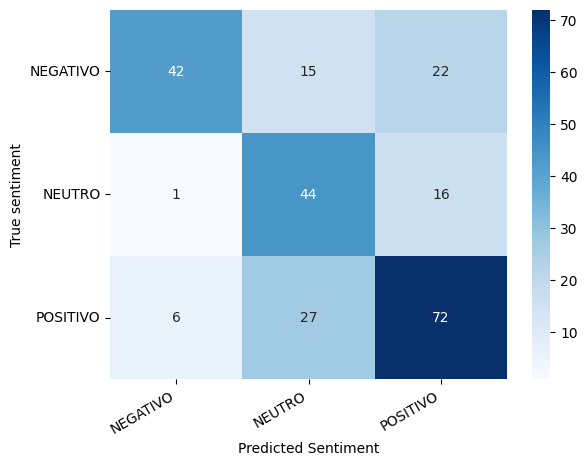

({'NEGATIVO': 0.057368252, 'NEUTRO': 0.5906888, 'POSTIVO': 0.3322582, 'IRONIA': 0.019684782}, 'NEUTRO')


In [9]:
# Obtener las predicciones
results = verify_model(classificator, test_loader, tokenizer)

In [11]:
del classificator
torch.cuda.empty_cache()

# 4. Creacion y evaluacion del modelo sin el bert entrenado

## 4.1 Entrenamiento

In [12]:
torch.manual_seed(SEED)
classificator_no_bert = SentimentAnalysis(BERT_MODEL, 0.4, 4, 256, 128, False).to(DEVICE)
count_parameters(classificator_no_bert)

230276

In [13]:
criterio, optimizer = get_loss_opt(classificator_no_bert)
train(classificator_no_bert, '../StoredModels/Mejores_guardados_no_bert.pt', train_loader, val_loader, optimizer, criterio)

 32%|█████████████▌                             | 19/60 [05:41<11:40, 17.09s/it]


Epoch: 20 | Training acc: 0.5622119815668203 | Training loss: 0.11874893423660071 | Val acc: 0.6270491803278688 | Val loss: 0.10891356648968868
------------------------------------------------------------------------------------------------------------------------------------------------------


 65%|███████████████████████████▉               | 39/60 [11:24<05:58, 17.09s/it]


Epoch: 40 | Training acc: 0.5842293906810035 | Training loss: 0.11579573752632277 | Val acc: 0.6475409836065574 | Val loss: 0.1052616118896203
------------------------------------------------------------------------------------------------------------------------------------------------------


 98%|██████████████████████████████████████████▎| 59/60 [17:05<00:17, 17.05s/it]


Epoch: 60 | Training acc: 0.5970302099334357 | Training loss: 0.11412462051929234 | Val acc: 0.6598360655737705 | Val loss: 0.10350799731543807
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|███████████████████████████████████████████| 60/60 [17:05<00:00, 17.10s/it]


(inf, 0.5970302099334357)

## 4.2 Validación

In [14]:
# Cargar un modelo que ya había sido Finetuneado
checkpoint_classifier = torch.load(
    "../StoredModels/Mejores_guardados_no_bert.pt",
    map_location=torch.device(DEVICE)
)

classificator_no_bert.load_state_dict(checkpoint_classifier['model_state_dict'])

<All keys matched successfully>

100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 18.37it/s]


Statistics: 
              precision    recall  f1-score   support

    NEGATIVO       0.62      0.67      0.64        79
      NEUTRO       0.51      0.62      0.56        61
    POSITIVO       0.69      0.55      0.61       105

    accuracy                           0.61       245
   macro avg       0.60      0.62      0.61       245
weighted avg       0.62      0.61      0.61       245



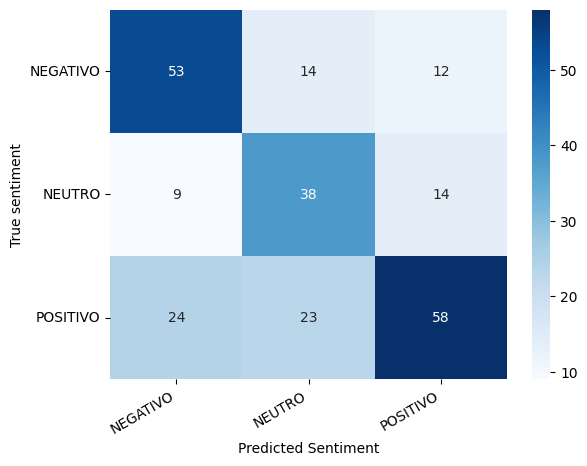

({'NEGATIVO': 0.065575294, 'NEUTRO': 0.6479403, 'POSTIVO': 0.28115696, 'IRONIA': 0.005327489}, 'NEUTRO')


In [15]:
# Obtener las predicciones
verify_model(classificator_no_bert, test_loader, tokenizer)

In [16]:
del classificator_no_bert
torch.cuda.empty_cache()

In [11]:
results.to_csv('../Validation/Sentiment.csv')